In [1]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from relscalenet.models.relscale_cache import RelScaleNetCached
from relscalenet.dataset_reader import EvaluationDataset
import relscalenet.geometry as geom
from relscalenet.visualization import make_heatmap, draw_heatmap

In [2]:
KEYPOINTS = "spsg"
GT_INLIER_THRESHOLD = 1.5

weights_path = "weights/model_final.pth"
data_path = f"data/scannet1500_{KEYPOINTS}.h5"
images_path = "data/scannet1500-images/images"
cache_path = f"{KEYPOINTS}_relscale_cache.h5"

### Calculate relative depths
Loads precomputed estimations if available.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
relscalenet = RelScaleNetCached(weights_path, device)
relscalenet.load_from_h5(cache_path)

dataset = EvaluationDataset(data_path, images_path)
relative_depths = {
    "pred": [],
    "gt": [],
}
inlier_ratios = []

for pair in tqdm(dataset, desc="Calculating relative depths"):
    im1_path, im2_path = pair.image_paths()
    x1, x2 = pair.matches()

    if len(x1) == 0:
        # No matches; skip image pair.
        continue

    # Predict relative scale
    relscale_pred = relscalenet.predict_image_pair(im1_path, im2_path, x1, x2)

    # Convert relative scale (gamma) to relative depth (sigma)
    cam1, cam2 = pair.cameras()
    f1 = cam1['params'][0:2].mean()
    f2 = cam2['params'][0:2].mean()
    reldepth_pred = relscale_pred * f2 / f1
    
    # Figure out ground truth relative depths        
    x1, x2 = pair.matches()
    K1, K2 = pair.calib_matrices()
    x1_calib = geom.calibrate_pts(x1, K1)
    x2_calib = geom.calibrate_pts(x2, K2)

    R_gt, t_gt = pair.relative_pose()
    X = geom.triangulate(R_gt, t_gt, x1_calib, x2_calib)
    X2 = X @ R_gt.T + t_gt
    lambda1 = X[:,2]
    lambda2 = X2[:,2]
    reldepth_gt = lambda2 / lambda1
    
    # Get ground-truth inliers
    F = pair.fundamental_matrix()
    err_gt = geom.sampson_error(F, x1, x2)
    inl_gt = err_gt < GT_INLIER_THRESHOLD

    relative_depths["pred"].extend(list(reldepth_pred[inl_gt].flatten()))
    relative_depths["gt"].extend(list(reldepth_gt[inl_gt]))
    inlier_ratios.append(inl_gt.mean())

relscalenet.cache.close()

Calculating relative depths:   0%|          | 0/1500 [00:00<?, ?it/s]

### Calculate relative depth estimation errors

In [4]:
relative_depths["pred"] = np.array(relative_depths["pred"])
relative_depths["gt"] = np.array(relative_depths["gt"])

error = np.abs(relative_depths["pred"] -relative_depths["gt"])
print("Median error:", np.median(error))
print("GT median inlier ratio:", np.median(inlier_ratios))

Median error: 0.08252846517766643
Median inlier ratio: 0.1962962962962963


### Plot heatmap

Text(0, 0.5, 'Ground Truth $\\sigma$')

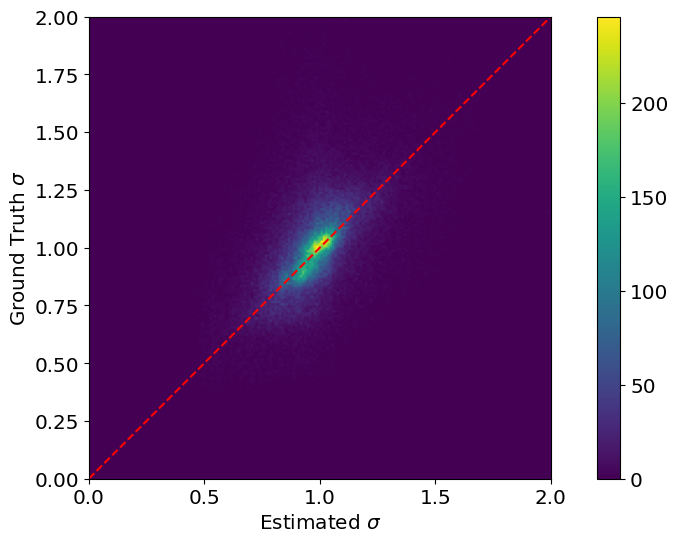

In [5]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'legend.loc': 'lower right',
         'figure.titlesize': 'xx-large',
}
plt.rcParams.update(params)

fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
heatmap_pred, extent_pred, xedges_pred, yedges_pred = make_heatmap(relative_depths["pred"], relative_depths["gt"], bins=200, maxval=2)
vmax = heatmap_pred.max()
draw_heatmap(ax, heatmap_pred, extent_pred, vmax=vmax)
ax.set_ylabel(r'Ground Truth $\sigma$')
